In [92]:
import os
import pickle
os.getcwd()

'/Users/gimpuleumoe/Documents/TUM2020S/2020-pooreumoe-msc-thesis/code/CP_dec'

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac
import pickle
# import some useful functions (they are available in utils.py)
# from utils import *

In [94]:
from tensorly.decomposition import candecomp_parafac

In [95]:
# Load Tensor
with open('../pkl/COVID_sorted_W_tensors_ver2.pkl', 'rb') as f:
    travel_data = pickle.load(f)

In [96]:
travel_data.shape

(22, 54, 108)

In [97]:
# Create serial tensors by slicing the time interval.
W = 1 # window size
serial_tensors = []
for i in range(len(travel_data)-W+1):
    serial_tensors.append(travel_data[i:i+1])
serial_tensors = np.array(serial_tensors)

In [98]:
serial_tensors.shape

(22, 1, 54, 108)

In [126]:
rank = 15
A = np.random.random((serial_tensors[0].shape[1], rank)) #node
B = np.random.random((serial_tensors[0].shape[2], rank)) #feature
C = np.random.random((serial_tensors[0].shape[0], rank)) #time
# init_ABC = candecomp_parafac.initialize_factors(travel_data, rank=rank)
# A = init_ABC[1]
# B = init_ABC[2]
# C = np.array([init_ABC[0][0]])

A_array = []
C_array = []
Ct_B =0
B_At =0
alpha = 0.1
beta = 0.1
T_interval = len(serial_tensors)

for t in range(T_interval):
    Xt = serial_tensors[t]
    
  # optimiza A
    Ct_B = khatri_rao([C, B])
    Xt_mode1_transpose = tl.unfold(Xt, mode=1).T
    X = np.concatenate((Xt_mode1_transpose, np.sqrt(alpha)*A.T), axis=0)
    I = np.identity(A.shape[1])
    F = np.concatenate((Ct_B, np.sqrt(alpha)*I), axis=0)
    A = np.linalg.lstsq(F,X, rcond=None)[0].T
    A_array.append(A)

    # optimize C
    B_At = khatri_rao([B, A])
    Xt_mode3_transpose = tl.unfold(Xt, mode=0).T
    X = np.concatenate((Xt_mode3_transpose, np.sqrt(beta)*C.T), axis=0)
    I = np.identity(C.shape[1])
    F = np.concatenate((B_At, np.sqrt(beta)*I), axis=0)
    C = np.linalg.lstsq(F,X, rcond=None)[0].T
    C_array.append(C)

    if t % int(T_interval * .1) == 0:
        res_a = np.square(Ct_B.dot(A.T) - Xt_mode1_transpose)
        res_c = np.square(B_At.dot(C.T) - Xt_mode3_transpose)
        print("interation:", t, "| Loss (A):", res_a.mean(), "| Loss (C):", res_c.mean())

interation: 0 | Loss (A): 0.0007875711930133524 | Loss (C): 0.0006903611880668742
interation: 2 | Loss (A): 0.004449069147528426 | Loss (C): 0.004582536328808869
interation: 4 | Loss (A): 0.0308121524202868 | Loss (C): 0.03163031034409886
interation: 6 | Loss (A): 0.13319717625805974 | Loss (C): 0.14202221322956188
interation: 8 | Loss (A): 0.09225744897504687 | Loss (C): 0.09551520235941287
interation: 10 | Loss (A): 0.08386321468162057 | Loss (C): 0.08460542409378526
interation: 12 | Loss (A): 0.004824781168830986 | Loss (C): 0.004766589904818211
interation: 14 | Loss (A): 0.0047904173615487804 | Loss (C): 0.004775660508150047
interation: 16 | Loss (A): 0.03967119642558512 | Loss (C): 0.04072877728829198
interation: 18 | Loss (A): 0.15207353149365302 | Loss (C): 0.15366538906690824
interation: 20 | Loss (A): 0.00033664411179481677 | Loss (C): 2.1926431336680402e-10


In [127]:
np.array(C_array).shape

(22, 1, 15)

In [128]:
# optimize B
# X = np.concatenate(, axis=0)
X_concat = tl.unfold(serial_tensors[0], mode=2).T
for x in range(len(serial_tensors)):
    if x>0:
        XtT_unfold = tl.unfold(serial_tensors[x], mode=2).T
        X_concat = np.concatenate((X_concat, XtT_unfold))

F_concat = khatri_rao([C_array[0], A_array[0]])
for i in range(len(C_array)):
    if i >0:
        F_concat = np.concatenate((F_concat, khatri_rao([C_array[i], A_array[i]])))
        
B = np.linalg.lstsq(F_concat,X_concat, rcond=None)[0].T

In [129]:
# Error comparision 

res_b_array=[]
res_rand_b_array=[]
for i in range(len(serial_tensors)):
    Xt = serial_tensors[i]
    Xt_mode2_transpose = tl.unfold(Xt, mode=2).T
    res_b = np.square(khatri_rao([A,C]).dot(B.T) - Xt_mode2_transpose)
    res_b_array.append(res_b.mean())
    rB = np.random.random((serial_tensors[0].shape[2], rank))
    rand_res_b = np.square(khatri_rao([A,C]).dot(rB.T) - Xt_mode2_transpose)
    res_rand_b_array.append(rand_res_b.mean())
#     print(res_b.mean(), rand_res_b.mean())

res_a = np.square(khatri_rao([C, B]).dot(A.T) - Xt_mode1_transpose)

res_c = np.square(khatri_rao([B, A]).dot(C.T) - Xt_mode3_transpose)
print(np.mean(res_b_array[10:]), np.mean(res_rand_b_array[10:]))
print(res_a.mean(), np.mean(res_b_array[10:]), res_c.mean())

0.04086648031277034 0.04086648376507932
9.172967899220193e-15 0.04086648031277034 9.172967899220193e-15


In [130]:
np.array(A_array).shape

(22, 54, 15)

In [131]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
# save_object(home_adj_list, '../pkl/[weekly]home_adj_from20180107_2.pkl')

In [132]:
# save_object(A_array, '../pkl/COVID_Aopt.pkl')
# save_object(C_array, '../pkl/COVID_Copt.pkl')
# save_object(B, '../pkl/COVID_Bopt.pkl')

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

In [134]:
# with open('../pkl/COVID_Aopt.pkl', 'rb') as f:
#     A_array = pickle.load(f)
    
# with open('../pkl/COVID_Bopt.pkl', 'rb') as f:
#     B = pickle.load(f)
    
# with open('../pkl/COVID_Copt.pkl', 'rb') as f:
#     C_array = pickle.load(f)

In [135]:
Aopt_array = A_array
Copt_array = C_array
Bstar = B
np.array(Aopt_array).shape # time x nodes # rank (21 54 19)
print(Bstar.shape) # Fature x rank
np.array(Copt_array).shape # time x 1 x rank

(108, 15)


(22, 1, 15)

In [136]:
week_slices = pd.date_range('2020-01-19', periods=23, freq='W')

In [137]:
xaxis = week_slices[1:]

In [138]:
with open('../pkl/new_COVID_order.pkl', 'rb') as f:
    new_order = pickle.load(f) 

In [139]:
with open('../pkl/COVID_label_dict.pkl', 'rb') as f:
    label_dict = pickle.load(f) 

In [140]:
countries = label_dict

In [141]:
label_dict

{0: 'Jungnang-gu',
 1: 'Dongjak-gu',
 2: 'Yangcheon-gu',
 3: 'Guro-gu',
 4: 'Gangnam-gu',
 5: 'Jung-gu',
 6: 'Jongno-gu',
 7: 'Eunpyeong-gu',
 8: 'Gangseo-gu',
 9: 'Yeongdeungpo-gu',
 10: 'Dongdaemun-gu',
 11: 'Songpa-gu',
 12: 'Seongdong-gu',
 13: 'Geumcheon-gu',
 14: 'Gwanak-gu',
 15: 'Seocho-gu',
 16: 'Seodaemun-gu',
 17: 'Gangbuk-gu',
 18: 'Yongsan-gu',
 19: 'Nowon-gu',
 20: 'Mapo-gu',
 21: 'Ansan-si',
 22: 'Seongbuk-gu',
 23: 'Goyang-si',
 24: 'Seongnam-si',
 25: 'Gwangjin-gu',
 26: 'Dobong-gu',
 27: 'Namyangju-si',
 28: 'Gangdong-gu',
 29: 'Anyang-si',
 30: 'Guri-si',
 31: 'Suwon-si',
 32: 'Paju-si',
 33: 'Gwangmyeong-si',
 34: 'Gimpo-si',
 35: 'Anseong-si',
 36: 'Gunpo-si',
 37: 'Uijeongbu-si',
 38: 'Gwacheon-si',
 39: 'Icheon-si',
 40: 'Pyeongtaek-si',
 41: 'Hanam-si',
 42: 'Siheung-si',
 43: 'Yangpyeong-gun',
 44: 'Dongducheon-si',
 45: 'Yongin-si',
 46: 'Gwangju-si',
 47: 'Bucheon-si',
 48: 'Yeoncheon-gun',
 49: 'Yeoju-si',
 50: 'Hwaseong-si',
 51: 'Uiwang-si',
 52: 'Pocheon-

In [142]:
LOF_by_countries = []
for i in range(Aopt_array[0].shape[0]):
#     X = np.array(np.exp(Aopt_array))[:,i,:]
    X = np.array(Aopt_array)[:,i,:]
    clf = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
    clf.fit(X)
    neg_scores = clf.negative_outlier_factor_
#     lof_scores = (np.max(neg_scores) - neg_scores)/(np.max(neg_scores) - np.min(neg_scores))
    lof_scores = neg_scores * -1
    LOF_by_countries.append(lof_scores)
    

In [143]:
# # travel_data.shape
# tensors = travel_data[:,:,:54]

# cnt_num = 4
# intraffic = np.sum(tensors[:,:,cnt_num], 1) #in-traffic
# print(intraffic)

# plt.figure(figsize=(12,5))
# plt.scatter(xaxis, intraffic)
# plt.axvline(x=xaxis[-17], linestyle='-', color='red', label="Massive spread")
# plt.title(str(label_dict[cnt_num])+ " intraffic")

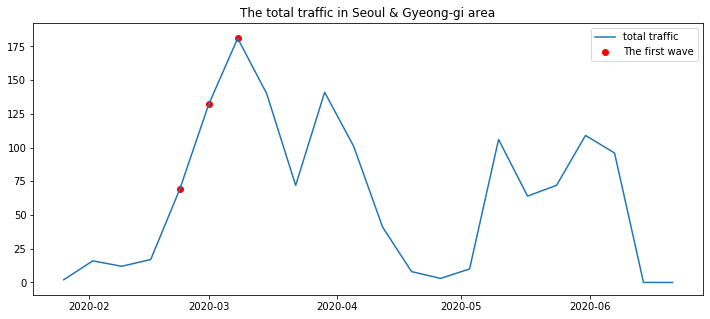

In [144]:
# travel_data.shape
tensors = travel_data[:,:,:54]
tensors.shape
xaxis = week_slices[1:]

traffic = np.sum(np.sum(tensors, 1),1) #in-traffic
plt.figure(figsize=(12,5))
plt.plot(xaxis, traffic, label= 'total traffic')
plt.scatter(xaxis[3+1:6+1], traffic[3+1:6+1], color='red', label = 'The first wave')
plt.title("The total traffic in Seoul & Gyeong-gi area")
plt.legend()

In [145]:
from datetime import datetime  
from datetime import timedelta  

[ 0.  0.  0.  0.  5. 14. 21. 14.  4.  9.  5.  4.  2.  0.  1. 19.  7. 11.
 10.  5.  0.  0.]


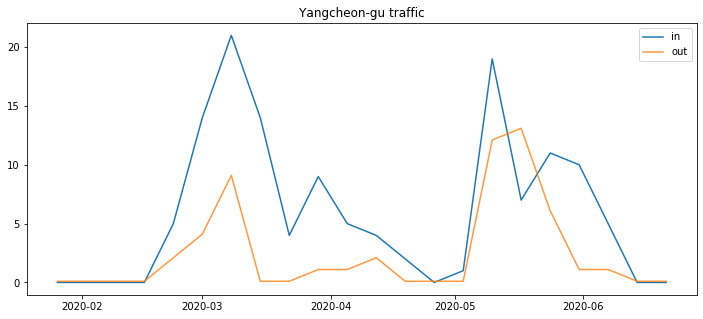

In [146]:
# travel_data.shape
tensors = travel_data[:,:,:54]
tensors.shape

cnt_num = 2
intraffic = np.sum(tensors[:,:,cnt_num], 1) #in-traffic
outtraffic = np.sum(tensors[:,cnt_num,:], 1) #outtraffic
print(intraffic)

plt.figure(figsize=(12,5))
plt.plot(xaxis, intraffic, label= 'in')
plt.plot(xaxis, outtraffic+0.1, label='out', alpha=0.8)
# plt.fill_between([xaxis[-19] + timedelta(days=1.5),xaxis[-17]], 0, 23, color='magenta', alpha=0.15, label = 'Surge in carriers mobility: 23.Feb ~ 29.Feb')
plt.title(str(label_dict[cnt_num])+ " traffic")
plt.legend()

In [147]:
# for i in range(54):
#     node = i
#     intraffic = np.sum(tensors[5,:,node])- np.sum(tensors[4,:,node]) #in-traffic
#     if(intraffic >4):
#         print(i,label_dict[node],intraffic)

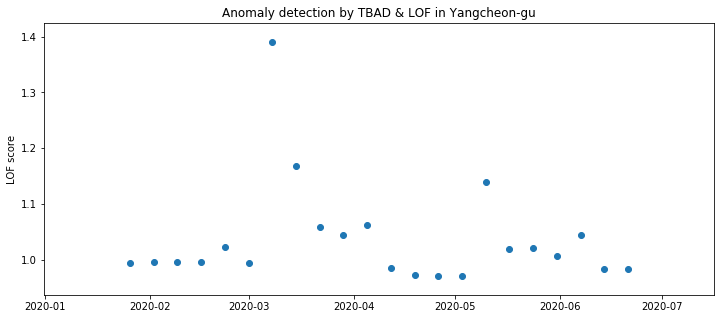

In [148]:
plt.figure(figsize=(12,5))
cnt_num = 2
plt.scatter(xaxis,LOF_by_countries[cnt_num])
# plt.axvline(xaxis[3], color='tab:purple', label="The initial confirmation")
# plt.legend()
plt.ylabel('LOF score')
plt.title('Anomaly detection by TBAD & LOF in ' + str(label_dict[cnt_num]))
plt.show()
# plt.title('LOF score of ' + countries[18])

In [149]:
# travel_data.shape
tensors = travel_data[:,:,:54]
tensors.shape

cnt_num = 3
intraffic = np.sum(tensors[:,:,cnt_num], 1) #in-traffic
print(intraffic)

# plt.figure(figsize=(12,5))
# plt.scatter(xaxis, intraffic)
# plt.title(str(label_dict[cnt_num])+ " intraffic")

[ 0.  0.  0.  0.  2.  7. 33. 12. 14.  1.  2.  0.  0.  0.  0.  1.  3.  1.
  1.  4.  0.  0.]


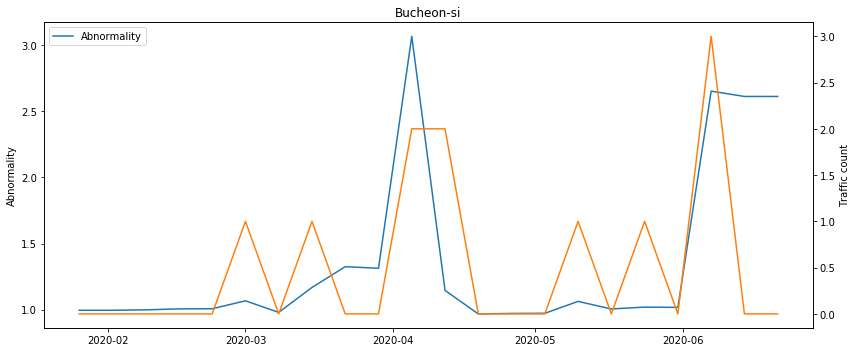

In [153]:
# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
fig, ax1 = plt.subplots(figsize=(12,5))

cnt_num = 47

color = 'tab:red'
# ax1.set_xlabel('Date')
ax1.set_ylabel('Abnormality')
ax1.plot(xaxis,LOF_by_countries[cnt_num], label= "Abnormality")
ax1.tick_params(axis='y')
plt.legend(loc=2)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Traffic count')  # we already handled the x-label with ax1
ax2.tick_params(axis='y')

intraffic = np.sum(tensors[:,:,cnt_num], axis=1)
outtraffic = np.sum(tensors[:,cnt_num,:], axis=1)
ax2.plot(xaxis, intraffic+outtraffic, label= 'total traffic', color='#ff7f0e')
# plt.legend(loc=1)
plt.title(label_dict[cnt_num])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

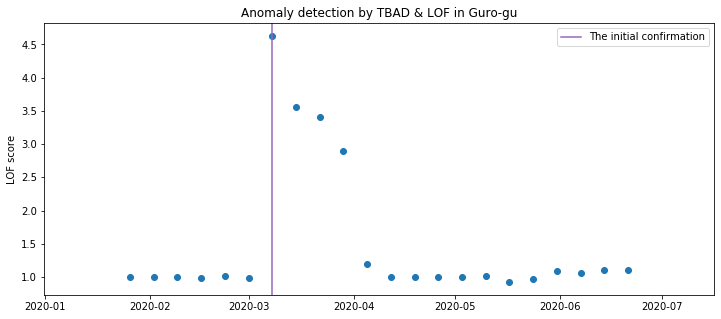

In [33]:
plt.figure(figsize=(12,5))
plt.scatter(xaxis,LOF_by_countries[3])
plt.axvline(xaxis[6], color='tab:purple', label="The initial confirmation")
plt.legend()
plt.ylabel('LOF score')
plt.title('Anomaly detection by TBAD & LOF in ' + str(label_dict[3]))
plt.show()
# plt.title('LOF score of ' + countries[18])

In [34]:
xaxis[-6]

Timestamp('2020-05-17 00:00:00', freq='W-SUN')

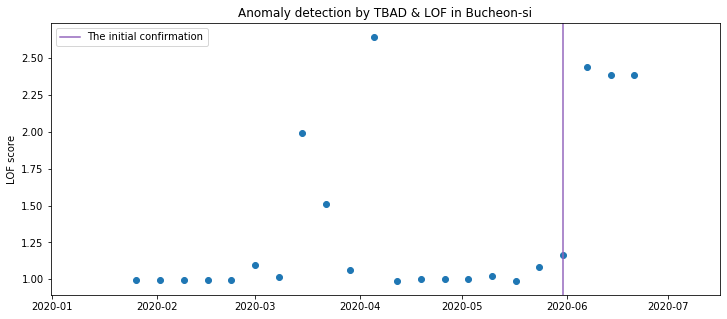

In [35]:
plt.figure(figsize=(12,5))
plt.scatter(xaxis,LOF_by_countries[47])
plt.axvline(xaxis[-4], color ='tab:purple', label="The initial confirmation")
plt.legend()
plt.ylabel('LOF score')
plt.title('Anomaly detection by TBAD & LOF in ' + str(label_dict[47]))
plt.show()


In [36]:
tensors.shape

(22, 54, 54)

In [37]:
# regularized_adj = np.mean(Bstar.T, axis=0)
regularized_adj = Bstar.T
raw_adj = np.mean(travel_data[:,:,:54], axis=0)

In [38]:
incoming = np.sum(regularized_adj[:,:54], axis=0)
outgoing = np.sum(regularized_adj[:,54:], axis=0)
raw_incoming = np.sum(raw_adj, axis=0)
raw_outgoing = np.sum(raw_adj, axis=1)

In [39]:
regularized_adj.shape

(15, 108)

In [40]:
def normalize(data):
#     a = data - np.min(data)
#     return (data-np.min(data))/(np.max(data)-np.min(data))*10
    return (data-np.mean(data))/np.std(data)
#     return data

In [41]:
net_traffic = normalize(outgoing+incoming) #- outgoing)
net_traffic_raw = normalize(raw_outgoing+raw_incoming) # - raw_outgoing)

In [42]:
print(np.std(net_traffic), np.std(net_traffic_raw))

0.9999999999999999 1.0000000000000002


In [43]:
# incom_df = pd.DataFrame([label_dict[0],incoming[0]]).T
# outgo_df = pd.DataFrame([label_dict[0],outgoing[0]]).T
net_traffic_df = pd.DataFrame([label_dict[0],net_traffic[0]]).T
raw_net_traffic_df = pd.DataFrame([label_dict[0],net_traffic_raw[0]]).T
for node in range(1,30):
    d1 = [label_dict[node],net_traffic[node]]
    d2 = [label_dict[node],net_traffic_raw[node]]
    net_traffic_df = net_traffic_df.append(pd.Series(d1, index=net_traffic_df.columns),ignore_index=True)
    raw_net_traffic_df = raw_net_traffic_df.append(pd.Series(d2, index=raw_net_traffic_df.columns),ignore_index=True)
#     incom_df= incom_df.append(pd.Series([label_dict[node],incoming[node]], index=incom_df.columns),ignore_index=True)
#     outgo_df= outgo_df.append(pd.Series([label_dict[node],outgoing[node]], index=outgo_df.columns),ignore_index=True)

In [44]:
# incom_df = pd.DataFrame([label_dict[0],incoming[0]]).T
# outgo_df = pd.DataFrame([label_dict[0],outgoing[0]]).T
net_traffic_df = pd.DataFrame([label_dict[0],net_traffic[0]]).T
raw_net_traffic_df = pd.DataFrame([label_dict[0],net_traffic_raw[0]]).T
for node in range(1,54):
    d1 = [label_dict[node],net_traffic[node]]
    d2 = [label_dict[node],net_traffic_raw[node]]
    net_traffic_df = net_traffic_df.append(pd.Series(d1, index=net_traffic_df.columns),ignore_index=True)
    raw_net_traffic_df = raw_net_traffic_df.append(pd.Series(d2, index=raw_net_traffic_df.columns),ignore_index=True)
#     incom_df= incom_df.append(pd.Series([label_dict[node],incoming[node]], index=incom_df.columns),ignore_index=True)
#     outgo_df= outgo_df.append(pd.Series([label_dict[node],outgoing[node]], index=outgo_df.columns),ignore_index=True)

-1.3451133153771688

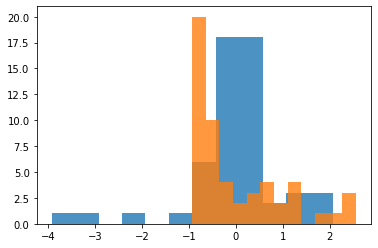

In [45]:
import scipy
plt.hist(net_traffic_df.iloc[:,1], bins=12, alpha=0.8)
plt.hist(raw_net_traffic_df.iloc[:,1], bins=12, alpha=0.8)
scipy.stats.skew(net_traffic_df.iloc[:,1])


-0.414158088391877


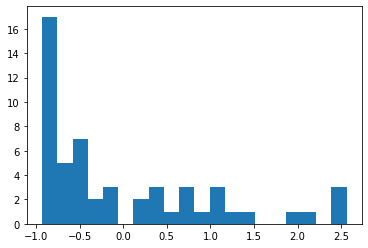

In [46]:
plt.hist(raw_net_traffic_df.iloc[:,1], bins=20)
scipy.stats.skew(raw_net_traffic_df.iloc[:,1])
print(np.median(raw_net_traffic_df.iloc[:,1]))

In [47]:
import folium
m = folium.Map(
    location=[37.5838699,126.9065831],
    zoom_start=11,
    tiles='Stamen Toner'
)

import json
geo_path = '../SocialGeo_measures/seoul_municipalities_geo.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

folium.Choropleth(geo_data=geo_str, 
                  data=net_traffic_df, 
                  columns=net_traffic_df.columns, 
                  fill_color='OrRd',
                  threshold_scale= np.arange(-3, 4, 1).tolist(),
                  fill_opacity=1,
                  line_opacity=0.5,
                  key_on='properties.SIG_ENG_NM').add_to(m)

m

ValueError: All values are expected to fall into one of the provided bins (or to be Nan). Please check the `bins` parameter and/or your data.

In [ ]:
import folium
m = folium.Map(
    location=[37.5838699,126.9065831],
    zoom_start=11,
    tiles='Stamen Toner'
)

import json
geo_path = '../SocialGeo_measures/seoul_municipalities_geo.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

folium.Choropleth(geo_data=geo_str, 
                  data=raw_net_traffic_df, 
                  columns=raw_net_traffic_df.columns, 
                  fill_color='OrRd',
                  threshold_scale= np.arange(-3, 4, 1).tolist(),
                  fill_opacity=1,
                  line_opacity=0.5,
                  key_on='properties.SIG_ENG_NM').add_to(m)

m

In [ ]:
# travel_data.shape
tensors = travel_data
time = 5
intraffic = np.sum(tensors[time,:,:54], 0) #in-traffic
outtraffic = np.sum(tensors[time,:,:54], 1) #outtraffic
total_traffic = intraffic + outtraffic
total_traffic

intraffic = np.sum(tensors[time-1,:,:54], 0) #in-traffic
outtraffic = np.sum(tensors[time-1,:,:54], 1) #outtraffic
total_traffic2 = intraffic + outtraffic
total_traffic = total_traffic-total_traffic2

In [ ]:
total_traffic_df = pd.DataFrame([label_dict[0],total_traffic[0]]).T
for node in range(1,54):
    d1 = [label_dict[node],total_traffic[node]]
    total_traffic_df = total_traffic_df.append(pd.Series(d1, index=total_traffic_df.columns),ignore_index=True)

total_traffic_df.columns=['SIG_ENG_NM','traffic']

In [ ]:
import folium
m = folium.Map(
    location=[37.5838699,126.9065831],
    zoom_start=11,
    tiles='Stamen Toner'
)

import json
geo_path = '../SocialGeo_measures/seoul_municipalities_geo.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

folium.Choropleth(geo_data=geo_str, 
                  data=total_traffic_df, 
                  columns=total_traffic_df.columns, 
                  fill_color='YlOrRd',
                  fill_opacity=1,
                  line_opacity=0.5,
                  threshold_scale=np.linspace(-15, 60.0, num=10),
                  key_on='properties.SIG_ENG_NM').add_to(m)

m